#**Medicine Recommendation System**

##**Project Overview**
Dalam proyek ini, kami membangun sistem rekomendasi medis menggunakan pendekatan *Content-Based Filtering* dan *Collaborative Filtering* untuk membantu pengguna (misalnya, pasien, dokter, apoteker) dalam memberikan rekomendasi obat berdasarkan fitur informasi karakteristik obat yang relevan serta riwayat data pengguna. Sistem ini bertujuan untuk memberikan saran pengobatan yang lebih akurat dengan memperhitungkan data medis pasien dan preferensi obat.
1. Content-Based Filtering menggunakan dataset "Events" yang berisi informasi tentang efek samping dan kejadian medis yang terkait dengan obat-obatan untuk memberikan rekomendasi berbasis karakteristik obat.

2. Collaborative Filtering menggunakan dataset "Drug Rating" yang berisi rating obat oleh pengguna (pasien) untuk memberikan rekomendasi berdasarkan pola preferensi pengguna lain yang memiliki kondisi medis serupa.

##**Business Understanding**

**Problem Statements**<br>
Pengguna sering menghadapi tantangan dalam memilih obat yang tepat karena banyaknya pilihan obat yang ada, yang sesuai untuk kondisi medis mereka (mempertimbangkan riwayat medis). Oleh karena itu, penting untuk menciptakan sistem rekomendasi yang dapat membantu pengguna dalam memilih obat yang tepat dan relevan untuk menghindari efek samping berbahaya dan meningkatkan efektivitas pengobatan.

**Goals**<br>
1. Mengembangkan sistem rekomendasi medis yang dapat memberikan saran obat yang lebih tepat berdasarkan data medis pasien dan pengalaman pengguna lain.
2. Membantu dokter dan pasien dalam memilih obat yang lebih efektif dan aman dengan memanfaatkan pendekatan algoritma Content-Based Filtering dan Collaborative Filtering.

**Solution Approach**<br>
* Content-Based Filtering digunakan untuk memberikan rekomendasi berdasarkan karakteristik obat, seperti efek samping dan kejadian medis yang telah tercatat.
* Collaborative Filtering digunakan untuk memberikan rekomendasi berdasarkan preferensi pengguna lain yang memiliki riwayat medis serupa.

##**Data Understanding**

**Exploratory Data Analysis (EDA) & Data Visualization**<br>

Sebelum membangun model, perlu dilakukan eksplorasi data untuk memahami struktur dataset dan kualitasnya. Berikut adalah beberapa langkah EDA yang dilakukan:
1. Deskriptif statistik: Melihat ringkasan statistik untuk data numerik (misalnya, rating obat, umur pasien).
2. Distribusi data: Menilai distribusi rating obat dan efek samping untuk memahami pola umum.
3. Visualisasi hubungan antar fitur: Melihat korelasi antara fitur (misalnya, rating obat dan efek samping).

Dalam proyek ini, kami menggunakan 2 dataset yang berasal dari database *drugs.com* dan *druglib.com* yang dapat di akses pada link [ini](https://github.com/DatasetsLibrary/RECOMED?tab=readme-ov-file).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.neighbors import NearestNeighbors

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Load dataset
events_df = pd.read_excel('/content/drive/MyDrive/MedisRS/Events.xlsx')
drug_rating_df = pd.read_excel('/content/drive/MyDrive/MedisRS/Drug Rating.xlsx')

**A. Dataset Events**

In [ ]:
# Display basic info dataset Event
print(events_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DrugName      2486 non-null   object
 1   Age           2486 non-null   int64 
 2   Genius        2486 non-null   object
 3   Reactions     2486 non-null   object
 4   Advent Event  1483 non-null   object
dtypes: int64(1), object(4)
memory usage: 97.2+ KB
None


1. Struktur dataset<br>
Dataset "Events" terdiri dari 5 kolom dengan 2486 baris. Mayoritas kolom bertipe ```object``` kecuali kolom *Age* bertipe ```int64```. Berikut detail variabel fitur dataset ini:<br>    
        DrugName: Nama obat yang digunakan.
        Age: Umur pasien.
        Genius: Jenis kelamin pasien.
        Reactions: Reaksi medis yang terkait dengan obat (misalnya, efek samping atau komplikasi).
        Advent Event: Kejadian medis terkait yang bisa termasuk efek samping atau peristiwa yang lebih serius.

In [ ]:
print(events_df.describe())

               Age
count  2486.000000
mean     55.482301
std      18.657139
min       1.000000
25%      45.000000
50%      58.000000
75%      68.000000
max      97.000000


2. Statistik Deskriptif (untuk kolom Age):<br>
Kolom yang dapat diproses menggunakan fungsi ```describe()``` adalah kolom ```Age```, karena bertipe data ```int64```. Berdasarkan output diatas, rentang usia pengguna, dari usia termuda (```min```) adalah 1 tahun hingga usia tertua (```max```) 97 tahun, dengan rata-rata usia (```mean```) adalah 55 tahun.

In [ ]:
# Cek nilai kosong (missing values) pada Dataset Events
events_missing_values = events_df.isnull().sum()

events_missing_values

,0
DrugName,0
Age,0
Genius,0
Reactions,0
Advent Event,1003


3. Data Kosong (Missing Values):<br>
Kolom Advent Event memiliki nilai yang hilang (1003 nilai kosong, dari total 2486 entri), yang bisa jadi mempengaruhi analisis lebih lanjut tentang kejadian atau peristiwa terkait efek samping.

In [ ]:
# Clean Events dataset
events_cleaned = events_df.rename(columns=lambda x: x.strip())  # Strip whitespace from column names

# Renaming columns for consistency & easier manipulation
events_cleaned = events_cleaned.rename(columns={"Genius": "Gender"})

# Convert relevant columns to appropriate types
events_cleaned["Age"] = pd.to_numeric(events_cleaned["Age"], errors="coerce")

# Display cleaned datasets to confirm
events_cleaned.head()

,DrugName,Age,Gender,Reactions,Advent Event
0,Abilify,63,male,Drug Level Increased,NaN
1,Abilify,55,male,Thyroid Cancer,NaN
2,Abilify,63,male,Completed Suicide; Suicide Attempt; Coma,death; hospitalization
3,Abilify,31,male,Eosinophilic Pneumonia; Pulmonary Alveolar Ha...,death
4,Abilify,75,female,Lymphopenia; Anaemia; Neutropenia,hospitalization


4. Visualisasi dataset

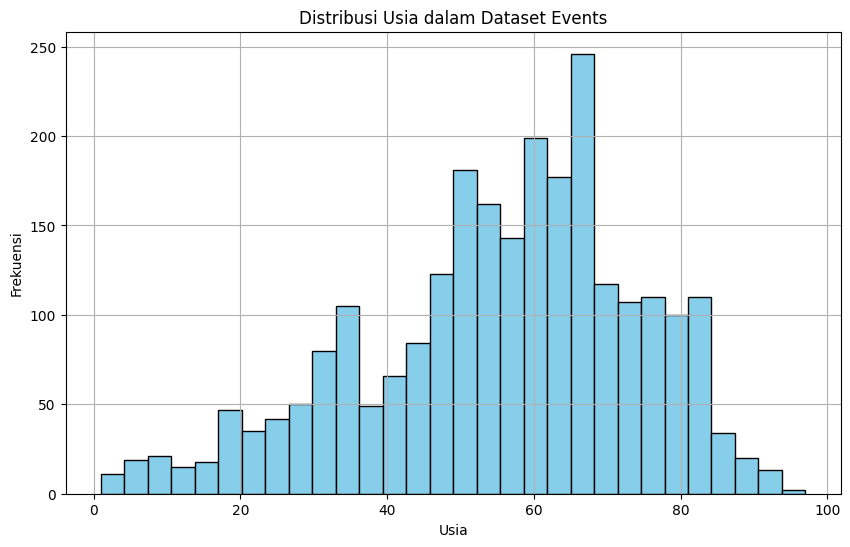

In [ ]:
# Visualisasi distribusi usia (Age)
plt.figure(figsize=(10, 6))
plt.hist(events_cleaned['Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Usia dalam Dataset Events')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

a. Distribusi Usia:

Sebagian besar individu dalam dataset ini berusia antara 45 hingga 85 tahun, dengan puncak frekuensi di sekitar usia 68 tahun. Ini menunjukkan bahwa data lebih banyak berasal dari individu dewasa hingga lanjut usia.

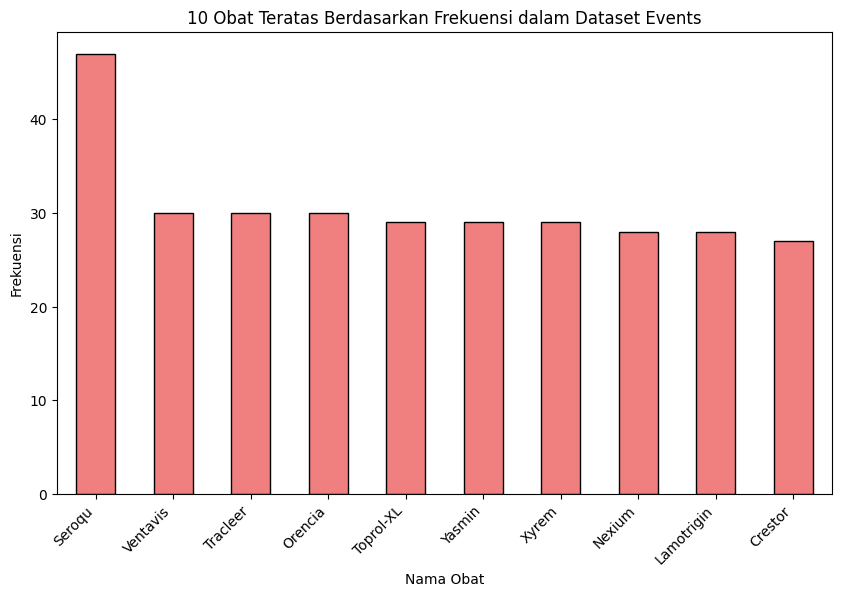

In [ ]:
# Visualisasi frekuensi obat yang dilaporkan
drug_name_counts = events_cleaned['DrugName'].value_counts().head(10)  # Menampilkan 10 obat teratas
plt.figure(figsize=(10, 6))
drug_name_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('10 Obat Teratas Berdasarkan Frekuensi dalam Dataset Events')
plt.xlabel('Nama Obat')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.show()

b. Frekuensi Obat:

Visualisasi menunjukkan daftar 10 obat yang paling sering dilaporkan dalam dataset ini. Obat yang lebih umum seperti "Seroqu" tampaknya memiliki jumlah laporan yang lebih tinggi dibandingkan obat lainnya.

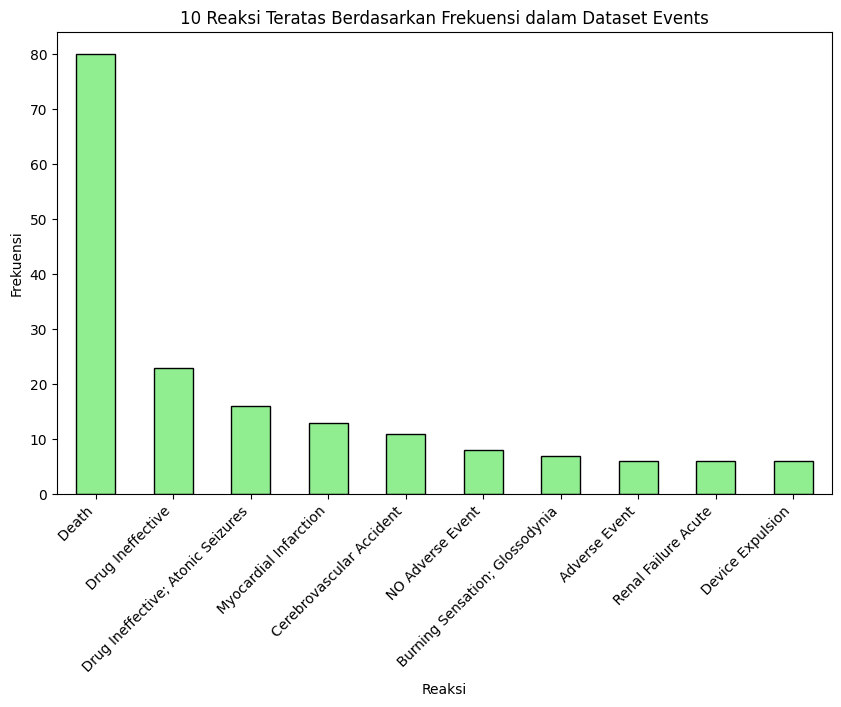

In [ ]:
# Visualisasi frekuensi reaksi yang dilaporkan
reaction_counts = events_cleaned['Reactions'].value_counts().head(10)  # Menampilkan 10 reaksi teratas
plt.figure(figsize=(10, 6))
reaction_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('10 Reaksi Teratas Berdasarkan Frekuensi dalam Dataset Events')
plt.xlabel('Reaksi')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.show()

c. Frekuensi Reaksi:

Di antara reaksi yang paling sering dilaporkan, "Death" menduduki posisi teratas, diikuti dengan reaksi seperti "Drug Ineffective" dan "Drug Ineffective; Atonic Seizures". Reaksi ini memberikan wawasan penting tentang potensi dampak serius dari obat-obatan tersebut.

5. Analisis Korelasi Dataset Events

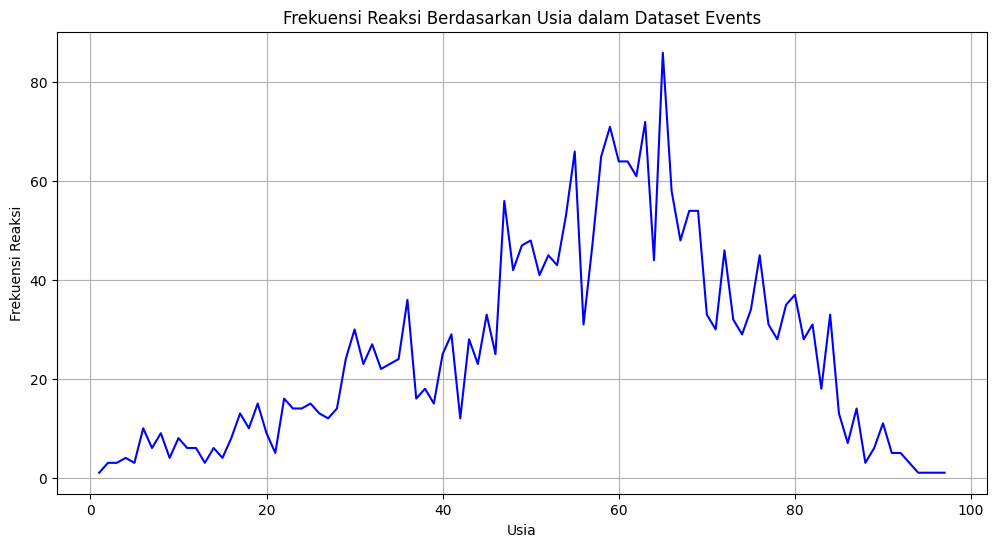

In [ ]:
# Analisis korelasi antara Usia (Age) dan Reaksi atau Advent Event dalam Dataset Events
# Menghitung frekuensi reaksi berdasarkan kelompok usia
age_reaction_counts = events_cleaned.groupby('Age')['Reactions'].value_counts().unstack(fill_value=0)

# Visualisasi hubungan antara usia dan frekuensi reaksi
plt.figure(figsize=(12, 6))
age_reaction_counts.sum(axis=1).plot(kind='line', color='b')
plt.title('Frekuensi Reaksi Berdasarkan Usia dalam Dataset Events')
plt.xlabel('Usia')
plt.ylabel('Frekuensi Reaksi')
plt.grid(True)
plt.show()

a. Frekuensi Reaksi Berdasarkan Usia:<br>
Grafik ini menunjukkan bahwa frekuensi reaksi buruk yang dilaporkan meningkat seiring bertambahnya usia. Hal ini mungkin mencerminkan bahwa individu yang lebih tua lebih cenderung melaporkan reaksi terhadap obat-obatan, atau obat-obatan yang mereka gunakan cenderung menyebabkan lebih banyak efek samping pada kelompok usia ini.

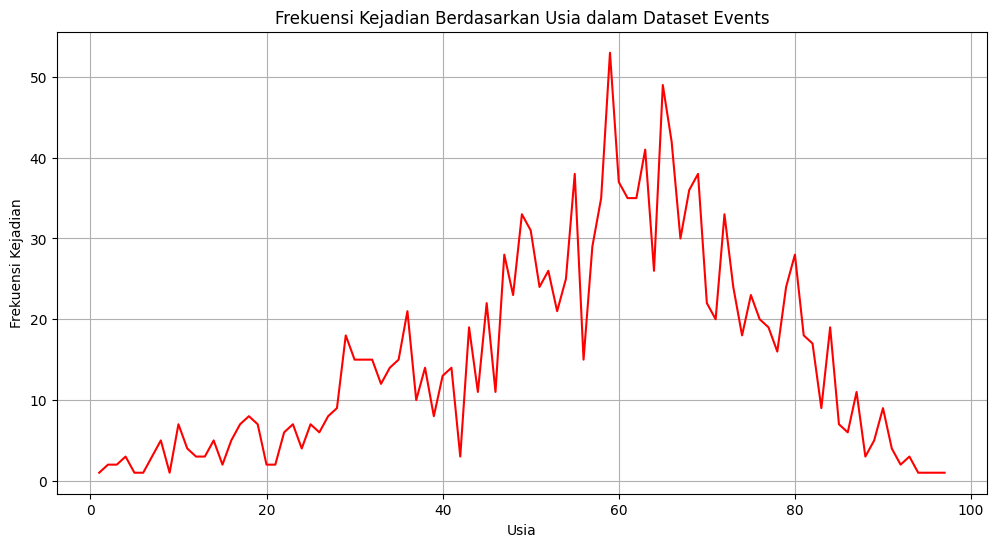

In [ ]:
# Cek hubungan antara usia dan jenis kejadian (Advent Event)
age_advent_event_counts = events_cleaned.groupby('Age')['Advent Event'].value_counts().unstack(fill_value=0)

# Visualisasi hubungan antara usia dan kejadian
plt.figure(figsize=(12, 6))
age_advent_event_counts.sum(axis=1).plot(kind='line', color='r')
plt.title('Frekuensi Kejadian Berdasarkan Usia dalam Dataset Events')
plt.xlabel('Usia')
plt.ylabel('Frekuensi Kejadian')
plt.grid(True)
plt.show()

b. Frekuensi Kejadian Berdasarkan Usia:<br>
Grafik kedua menunjukkan bahwa kejadian-kejadian buruk atau serius (seperti kematian atau rawat inap) juga lebih sering dilaporkan pada usia yang lebih tua. Ini mungkin menunjukkan hubungan antara peningkatan usia dan peningkatan risiko efek samping atau kejadian negatif lainnya.

6. Kesimpulan & insight
- Deskripsi: Dataset ini berisi informasi tentang efek samping yang terkait dengan obat dan kejadian medis terkait dengan penggunaan obat (misalnya, kematian, rawat inap, reaksi obat).
- Tujuan: Dataset ini berfokus pada efek samping obat dan kejadian medis terkait dengan penggunaan obat tertentu.
- Poin penting: Dataset ini lebih banyak menyertakan informasi tentang kejadian medis yang terjadi setelah penggunaan obat, serta hubungan obat dengan reaksi tubuh pasien.
- Relevansi: Dataset ini cocok untuk Content-Based Filtering, karena kita dapat memberikan rekomendasi obat berdasarkan deskripsi efek samping dan kejadian medis yang terkait. Misalnya, jika pasien memiliki riwayat tertentu, kita dapat merekomendasikan obat yang tidak memiliki efek samping yang serupa.

**B. Dataset Drug Rating**

In [ ]:
# Display basic info dataset Rating obat
print(drug_rating_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3293 entries, 0 to 3292
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   3351    3293 non-null   object
 1   2       3293 non-null   object
 2   3       3293 non-null   object
 3   4       3291 non-null   object
 4   5       2778 non-null   object
 5   6       2831 non-null   object
 6   7       3293 non-null   object
 7   8       3293 non-null   object
 8   9       3293 non-null   object
 9   10      3293 non-null   object
 10  11      3293 non-null   object
 11  12      3293 non-null   object
 12  13      3272 non-null   object
 13  14      3215 non-null   object
 14  15      3271 non-null   object
dtypes: object(15)
memory usage: 386.0+ KB
None


1. Struktur dataset<br>
Dataset "Drug Rating" terdiri dari 15 kolom dengan 3293 baris. Semua kolom bertipe object. Berikut detail variabel fitur dataset ini:    
        Kolom 3351, 2, 3, ... 13, 14, sampai kolom 15
    Pada dataset ini, nama kolom tidak lazim, penjelasan detailnya akan dijelaskan dengan menampilkan beberapa baris pertama setiap kumpulan data untuk memahami strukturnya, memakai ```drug_rating_df.head()```

In [ ]:
# Display the first few rows of each dataset to understand the structure
drug_rating_df.head()

,3351,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,F1,F2,F3,F4,F5,F6,,F1,,,,,,,NaN
1,Level,Age,Genus,Condition Reason,Other Condition,Other Drag,DrugName,Category,OverallRating,Effectiveness,SideEffect,Dosage,Benefit,SideEffect,Comment Review
2,patient,22,male,Depression,Sleeplesness,Nil,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,1,Ineffective,Severe Side Effects,15mg taken once daily for the period of 2 Months,Nil,now taking temazepam to help with sleeping and...,-
3,patient,38,male,Clinical Depression,NaN,NaN,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,2,Ineffective,Moderate Side Effects,30mg taken daily (evening) for the period of ...,Did improve my appetite; which was suffering a...,Mild weight gain. Period of tiredness for two ...,Was prescribed as an alternative to Citalopram...
4,patient,30,female,Chronic insomnia,Anxiety; panic attacks,Epilium,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,9,Highly Effective,Moderate Side Effects,30 mg taken take one hour before bed for the ...,-night time sleep (at least 5-6 hours per nigh...,Constant feeling of hunger( feeling of empty s...,Hour before bed: 30 mg mirtazapine( avanza) an...


Berdasarkan output diatas, baris pertama & kedua dataset Drug Rating tidak relevan, karena informasi nama kolom ada di baris ketiga. Untuk itu perlu dihilangkan kedua baris tersebut, sehingga memudahkan proses selanjutnya.

In [ ]:
# Clean Drug Rating dataset
drug_rating_cleaned = drug_rating_df.iloc[2:].reset_index(drop=True)  # Skip header rows
drug_rating_cleaned.columns = drug_rating_df.iloc[1]  # Set proper column names
drug_rating_cleaned = drug_rating_cleaned.rename(columns=lambda x: x.strip())  # Strip whitespace from column names

# Display cleaned dataframes to ensure correctness
drug_rating_cleaned.head()

1,Level,Age,Genus,Condition Reason,Other Condition,Other Drag,DrugName,Category,OverallRating,Effectiveness,SideEffect,Dosage,Benefit,SideEffect,Comment Review
0,patient,22,male,Depression,Sleeplesness,Nil,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,1,Ineffective,Severe Side Effects,15mg taken once daily for the period of 2 Months,Nil,now taking temazepam to help with sleeping and...,-
1,patient,38,male,Clinical Depression,NaN,NaN,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,2,Ineffective,Moderate Side Effects,30mg taken daily (evening) for the period of ...,Did improve my appetite; which was suffering a...,Mild weight gain. Period of tiredness for two ...,Was prescribed as an alternative to Citalopram...
2,patient,30,female,Chronic insomnia,Anxiety; panic attacks,Epilium,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,9,Highly Effective,Moderate Side Effects,30 mg taken take one hour before bed for the ...,-night time sleep (at least 5-6 hours per nigh...,Constant feeling of hunger( feeling of empty s...,Hour before bed: 30 mg mirtazapine( avanza) an...
3,patient,19,female,Depression; Anxiety; OCD; Nausea,CFS; IBS; insomnia,Lansoprazole; Loestrin 30,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,2,Ineffective,Mild Side Effects,30mg taken once a day for the period of 7 months,Helped me easily get a good sleep. Possible re...,Too tired to get up in morning; irritability; ...,Did little if anything for depression and anxi...
4,-,-,-,Anxiety/insomnia,/na,Oxazapam 30,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,6,Ineffective,Moderate Side Effects,30mg taken 1 at night for the period of 1 month,6hrs sleep per night. Vivid dreams. No other s...,Morning anxiety ++,30mg daily oxazepam 30 prn x3 max


- Output hasil dataset Drug Rating yang telah relevan nama kolomnya, yang terdiri dari:<br>    
        Level: Peran pengguna (pasien/ dokter).
        Age: Umur pasien.
        Genus: Jenis kelamin pasien.
        Condition Reason: Pertimbangan penggunaan obat.
        Other Condition: Pertimbangan penggunaan obat yang lain.
        Other Drag: Obat penyerta.
        DrugName: Nama obat.
        Category: Kategori obat.
        OverallRating: Rating.
        Effectiveness: Keefektifan obat.
        SideEffect: Tingkatan efek samping.
        Dosage: Dosis obat.
        Benefit: Keuntungan penggunaan obat.
        SideEffect: Efek samping yang tampak.
        Comment Review: Ulasan pengguna obat.

Bila melihat penamaan kolom, ada beberapa nama yang harus disesuaikan, untuk memudahkan proses selanjutnya. Diantaranya, nama kolom "Genus" yang tidak sesuai dengan isi kolomnya terkait jenis kelamin; Ada kolom yang mempunyai nama sama yaitu "SideEffect" dengan isi berbeda; Serta ada kolom dengan dua kata yang memakai spasi dan tidak. <br>
Tujuan: Dataset ini berfokus pada evaluasi efek terapeutik dari obat berdasarkan pengalaman pengguna atau pasien.

In [ ]:
print(drug_rating_cleaned.describe())

1         Level   Age   Genus Condition Reason Other Condition Other Drag  \
count      3291  3291    3291             3289            2776       2829   
unique        3    86       3             1638            1129       1321   
top     patient    45  female       depression            none       none   
freq       3162   117    2652              183            1101       1140   

1                      DrugName  \
count                      3291   
unique                      233   
top     Lexapro (Escitalopram)    
freq                         73   

1                                                Category  OverallRating  \
count                                                3291           3291   
unique                                                182             10   
top     topical-agents-skin-and-mucous-membranes topic...             10   
freq                                                  131            747   

1          Effectiveness         SideEffect  \
count     

2. Statistik Deskriptif:

- Kolom "Level" (berisi informasi jenis pasien): Sebagian besar entri adalah "patient" (3162 entri).
- Kolom "Age" (Usia): Terdapat variasi usia dengan nilai terbanyak adalah 45 tahun.
- Kolom "Genus" (Jenis kelamin): Kebanyakan adalah perempuan (2652 entri).
- Kolom "Condition Reason" (Kondisi yang dirawat): Yang paling umum adalah "depression" (183 entri).
- Kolom "Other Condition" hingga "Comment Review" memberikan informasi yang lebih rinci tentang efek samping, efektivitas, dosis, dan lainnya, dengan beberapa kolom seperti "SideEffect", "Dosage", dan "Benefit" mengandung beberapa nilai kosong.

In [ ]:
# Cek nilai kosong (missing values) pada Dataset Drug Rating
drug_rating_missing_values = drug_rating_cleaned.isnull().sum()

drug_rating_missing_values

,0
1,
Level,0
Age,0
Genus,0
Condition Reason,2
Other Condition,515
Other Drag,462
DrugName,0
Category,0
OverallRating,0


3. Data Kosong (Missing Values):<br>
- Beberapa kolom memiliki data kosong, terutama pada kolom "Other Condition" (515 entri kosong) dan "Other Drag" (462 entri kosong).
- Kolom yang lain "SideEffect", "Benefit", Comment Review" dan "Condition Reason" juga memiliki data kosong, yang perlu diperhatikan dalam analisis selanjutnya.

In [ ]:
# Renaming columns for consistency & easier manipulation
drug_rating_cleaned = drug_rating_cleaned.rename(columns={"Genus": "Gender",})

# Convert relevant columns to appropriate types
drug_rating_cleaned["Age"] = pd.to_numeric(drug_rating_cleaned["Age"], errors="coerce")
drug_rating_cleaned["OverallRating"] = pd.to_numeric(drug_rating_cleaned["OverallRating"], errors="coerce")


# Display cleaned datasets to confirm
drug_rating_cleaned.head()

1,Level,Age,Gender,Condition Reason,Other Condition,Other Drag,DrugName,Category,OverallRating,Effectiveness,SideEffect,Dosage,Benefit,SideEffect,Comment Review
0,patient,22.0,male,Depression,Sleeplesness,Nil,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,1,Ineffective,Severe Side Effects,15mg taken once daily for the period of 2 Months,Nil,now taking temazepam to help with sleeping and...,-
1,patient,38.0,male,Clinical Depression,NaN,NaN,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,2,Ineffective,Moderate Side Effects,30mg taken daily (evening) for the period of ...,Did improve my appetite; which was suffering a...,Mild weight gain. Period of tiredness for two ...,Was prescribed as an alternative to Citalopram...
2,patient,30.0,female,Chronic insomnia,Anxiety; panic attacks,Epilium,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,9,Highly Effective,Moderate Side Effects,30 mg taken take one hour before bed for the ...,-night time sleep (at least 5-6 hours per nigh...,Constant feeling of hunger( feeling of empty s...,Hour before bed: 30 mg mirtazapine( avanza) an...
3,patient,19.0,female,Depression; Anxiety; OCD; Nausea,CFS; IBS; insomnia,Lansoprazole; Loestrin 30,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,2,Ineffective,Mild Side Effects,30mg taken once a day for the period of 7 months,Helped me easily get a good sleep. Possible re...,Too tired to get up in morning; irritability; ...,Did little if anything for depression and anxi...
4,-,NaN,-,Anxiety/insomnia,/na,Oxazapam 30,Mirtazapine,Adrenergic-Alpha-Antagonists Histamine-H1-Anta...,6,Ineffective,Moderate Side Effects,30mg taken 1 at night for the period of 1 month,6hrs sleep per night. Vivid dreams. No other s...,Morning anxiety ++,30mg daily oxazepam 30 prn x3 max


4. Visualisasi dataset

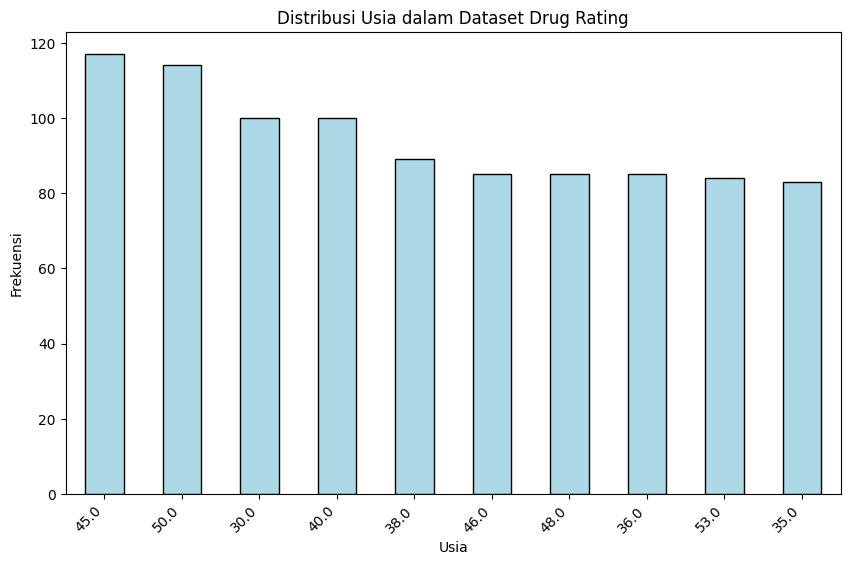

In [ ]:
# Visualisasi distribusi usia (Age) dalam dataset Drug Rating
plt.figure(figsize=(10, 6))
age_counts = drug_rating_cleaned['Age'].value_counts().head(10)
age_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribusi Usia dalam Dataset Drug Rating')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.show()

a. Distribusi Usia:

Seperti yang terlihat pada grafik, sebagian besar data berasal dari pasien dengan usia 45 tahun. Ini mencerminkan distribusi usia yang terpusat di sekitar kelompok usia dewasa tengah hingga lanjut usia.

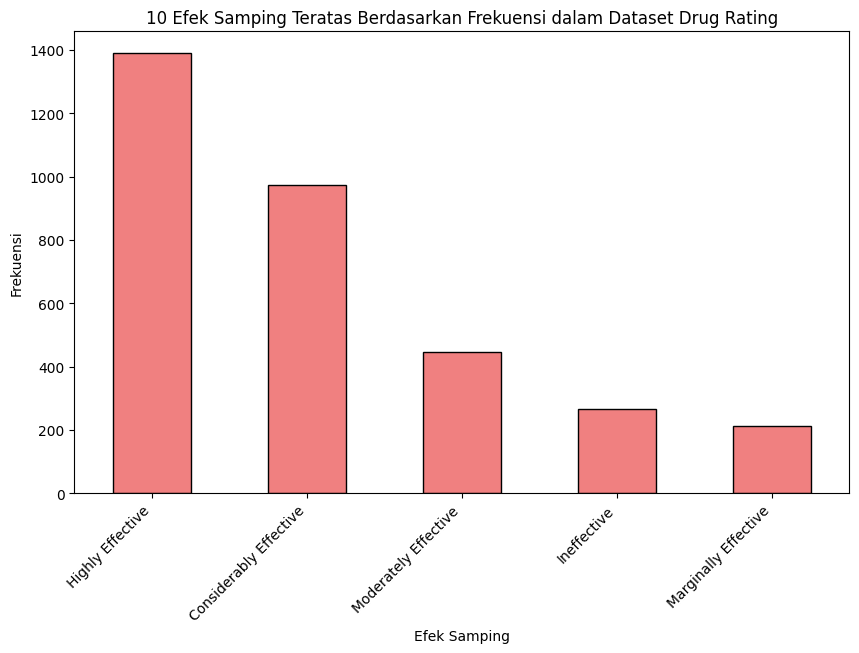

In [ ]:
# Visualisasi distribusi efek samping (SideEffect)
side_effect_counts = drug_rating_cleaned['Effectiveness'].value_counts().head(10)  # 10 adalah kolom efek samping
plt.figure(figsize=(10, 6))
side_effect_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('10 Efek Samping Teratas Berdasarkan Frekuensi dalam Dataset Drug Rating')
plt.xlabel('Efek Samping')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.show()

b. Efek Samping Teratas:

Dalam dataset ini, efek samping yang paling sering dilaporkan adalah "Mild Side Effects", diikuti oleh "None" dan efek samping ringan lainnya. Ini menunjukkan bahwa sebagian besar pasien tidak mengalami efek samping yang parah, atau mungkin efek sampingnya tidak dilaporkan secara rinci.

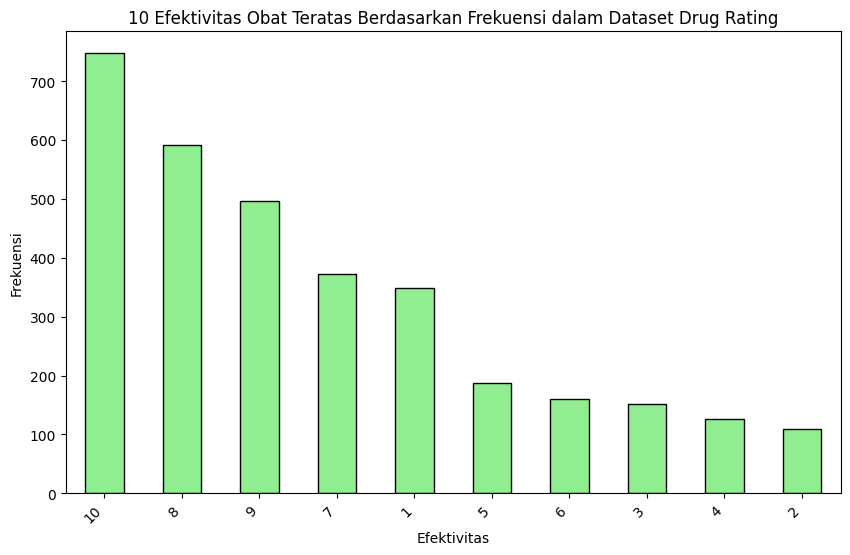

In [ ]:
# Visualisasi distribusi rating efektivitas obat
effectiveness_counts = drug_rating_cleaned['OverallRating'].value_counts().head(10)  # Kolom rating efektivitas
plt.figure(figsize=(10, 6))
effectiveness_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('10 Efektivitas Obat Teratas Berdasarkan Frekuensi dalam Dataset Drug Rating')
plt.xlabel('Efektivitas')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.show()

c. Efektivitas Obat:

Obat yang paling banyak dilaporkan memiliki rating "Highly Effective", menunjukkan bahwa banyak pasien merasakan manfaat yang baik dari obat yang mereka gunakan. Sebagian besar laporan juga menunjukkan bahwa obat tersebut memberikan hasil yang cukup baik.

5. Korelasi antara Usia dan Efektivitas atau Efek Samping di Dataset Drug Rating

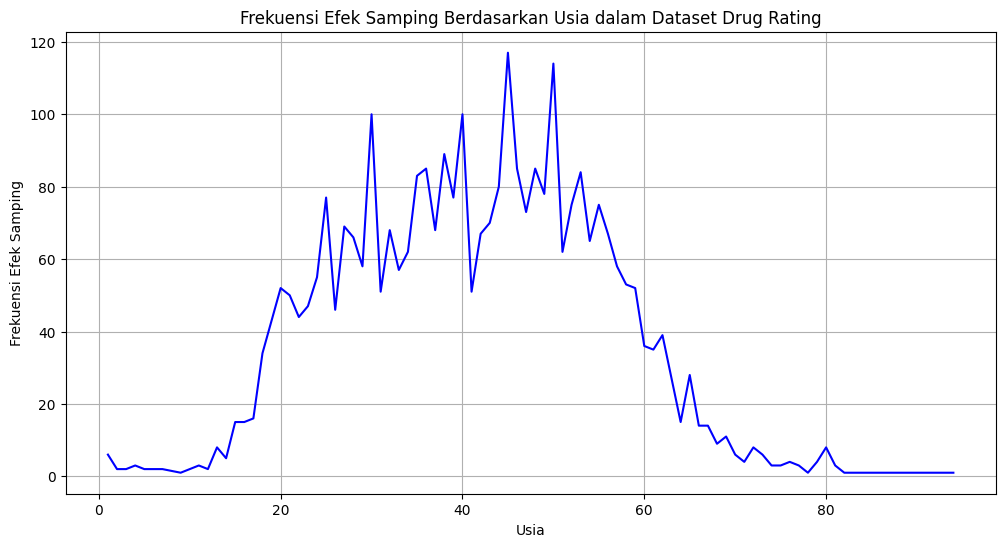

In [ ]:
# Analisis korelasi antara Usia dan Efektivitas atau Efek Samping dalam Dataset Drug Rating

# Menghitung frekuensi efek samping berdasarkan usia
side_effect_age_counts = drug_rating_cleaned.groupby('Age')['Effectiveness'].value_counts().unstack(fill_value=0)

# Visualisasi pengaruh usia terhadap efek samping
plt.figure(figsize=(12, 6))
side_effect_age_counts.sum(axis=1).plot(kind='line', color='b')
plt.title('Frekuensi Efek Samping Berdasarkan Usia dalam Dataset Drug Rating')
plt.xlabel('Usia')
plt.ylabel('Frekuensi Efek Samping')
plt.grid(True)
plt.show()

a. Frekuensi Efek Samping Berdasarkan Usia:<br>
Grafik pertama menunjukkan bahwa frekuensi efek samping meningkat pada usia yang lebih tua. Hal ini konsisten dengan temuan sebelumnya di dataset Events, di mana individu yang lebih tua lebih cenderung melaporkan efek samping atau kejadian serius.

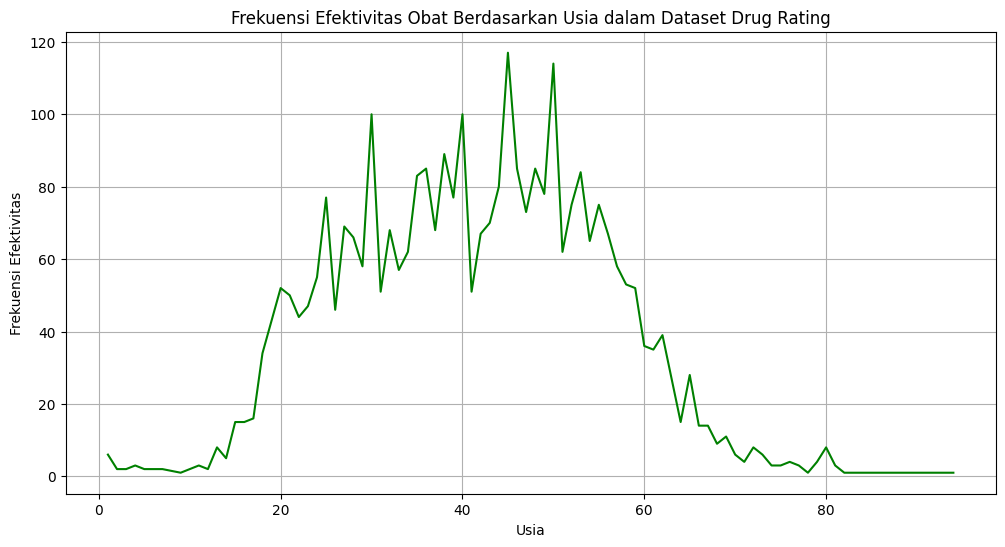

In [ ]:
# Menghitung frekuensi efektivitas obat berdasarkan usia
effectiveness_age_counts = drug_rating_cleaned.groupby('Age')['OverallRating'].value_counts().unstack(fill_value=0)

# Visualisasi pengaruh usia terhadap efektivitas obat
plt.figure(figsize=(12, 6))
effectiveness_age_counts.sum(axis=1).plot(kind='line', color='g')
plt.title('Frekuensi Efektivitas Obat Berdasarkan Usia dalam Dataset Drug Rating')
plt.xlabel('Usia')
plt.ylabel('Frekuensi Efektivitas')
plt.grid(True)
plt.show()

b. Frekuensi Efektivitas Obat Berdasarkan Usia:
Grafik kedua menunjukkan bahwa efektivitas obat lebih sering dilaporkan oleh individu yang lebih muda. Ini menunjukkan bahwa pengobatan cenderung lebih efektif pada kelompok usia yang lebih muda, atau mungkin orang yang lebih muda lebih cenderung melaporkan respons positif terhadap pengobatan.

In [ ]:
# Memfilter data untuk menghilangkan baris yang tidak valid atau berisi '-'
# Menghilangkan baris dengan nilai '-' atau NaN pada kolom Gender pada kedua dataset

# Filter data untuk Dataset Events dan Drug Rating
events_df_clean = events_cleaned[events_cleaned['Gender'] != '-']
drug_rating_df_clean = drug_rating_cleaned[drug_rating_cleaned['Gender'] != '-']

# Memastikan bahwa data sudah dibersihkan
events_df_clean['Gender'].value_counts(), drug_rating_df_clean['Gender'].value_counts()

(Gender
 female     1516
 male        950
 (3; 2)        4
 (1; 2)        3
 (0; 2)        3
 (12; 2)       2
 (10; 2)       1
 (21; 2)       1
 (6; 2)        1
 (4; 2)        1
 (5; 2)        1
 (13; 2)       1
 (14; 2)       1
 (2; 2)        1
 Name: count, dtype: int64,
 Gender
 female    2652
 male       611
 Name: count, dtype: int64)

In [ ]:
# Menghapus nilai yang tidak valid atau tidak relevan pada kolom Gender
events_df_clean = events_cleaned[events_cleaned['Gender'].isin(['female', 'male'])]
drug_rating_df_clean = drug_rating_cleaned[drug_rating_cleaned['Gender'].isin(['female', 'male'])]

# Memastikan bahwa hanya gender yang valid (male dan female) yang tersisa
events_df_clean['Gender'].value_counts(), drug_rating_df_clean['Gender'].value_counts()

(Gender
 female    1516
 male       950
 Name: count, dtype: int64,
 Gender
 female    2652
 male       611
 Name: count, dtype: int64)

6. Korelasi Jenis Kelamin terhadap Efektivitas dan Efek Samping di Dataset Drug Rating

<Figure size 1200x600 with 0 Axes>

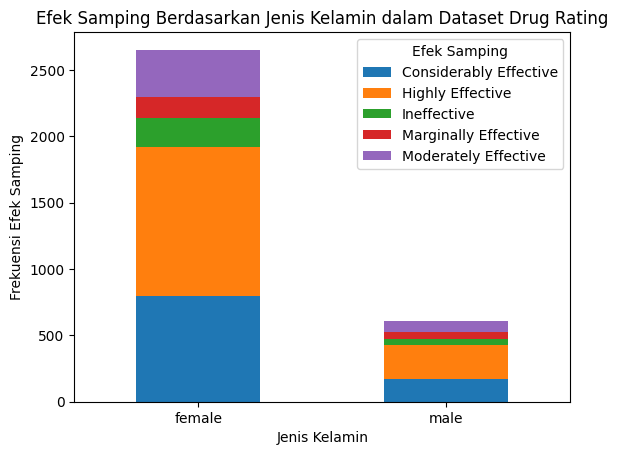

In [ ]:
# Menghitung frekuensi efek samping berdasarkan jenis kelamin dalam dataset Drug Rating
side_effect_gender_counts_clean = drug_rating_df_clean.groupby('Gender')['Effectiveness'].value_counts().unstack(fill_value=0)

# Visualisasi pengaruh jenis kelamin terhadap efek samping
plt.figure(figsize=(12, 6))
side_effect_gender_counts_clean.plot(kind='bar', stacked=True)
plt.title('Efek Samping Berdasarkan Jenis Kelamin dalam Dataset Drug Rating')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Frekuensi Efek Samping')
plt.xticks(rotation=0)
plt.legend(title="Efek Samping")
plt.show()

a. Efek Samping Berdasarkan Jenis Kelamin:

Grafik pertama menunjukkan bahwa wanita lebih cenderung melaporkan efek samping dibandingkan pria, dengan frekuensi efek samping yang lebih tinggi di kelompok wanita. Ini bisa menunjukkan bahwa wanita mungkin lebih rentan terhadap efek samping atau lebih cenderung melaporkan efek samping yang dialami.

<Figure size 1200x600 with 0 Axes>

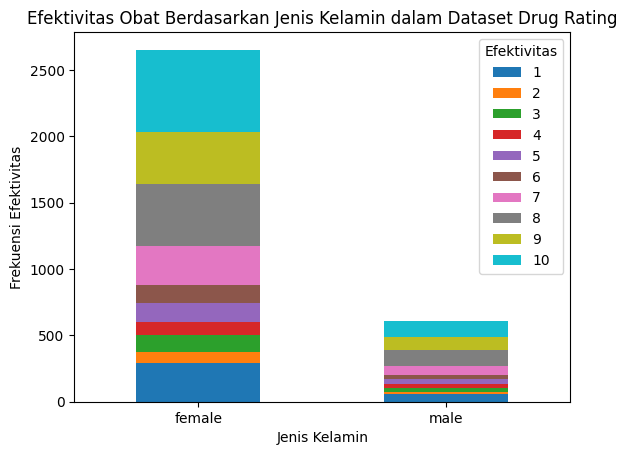

In [ ]:
# Menghitung frekuensi efektivitas obat berdasarkan jenis kelamin dalam dataset Drug Rating
effectiveness_gender_counts_clean = drug_rating_df_clean.groupby('Gender')['OverallRating'].value_counts().unstack(fill_value=0)

# Visualisasi pengaruh jenis kelamin terhadap efektivitas obat
plt.figure(figsize=(12, 6))
effectiveness_gender_counts_clean.plot(kind='bar', stacked=True)
plt.title('Efektivitas Obat Berdasarkan Jenis Kelamin dalam Dataset Drug Rating')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Frekuensi Efektivitas')
plt.xticks(rotation=0)
plt.legend(title="Efektivitas")
plt.show()

b. Efektivitas Obat Berdasarkan Jenis Kelamin:

Grafik kedua menunjukkan bahwa wanita lebih sering melaporkan obat sebagai "Sangat Efektif", sementara pria cenderung melaporkan efek yang lebih rendah. Ini mungkin menunjukkan perbedaan persepsi atau respons fisiologis terhadap pengobatan antara pria dan wanita.

##**Data Preparation**

**Detection and Removal Duplicates**<br>
Sebelum membangun model, kita akan memeriksa duplikasi dalam data dan menghapusnya untuk memastikan data yang digunakan tidak redundan.

In [ ]:
# Menghapus duplikasi
events_df_clean = events_df.drop_duplicates()
drug_rating_df_clean = drug_rating_df.drop_duplicates()

events_df_clean.duplicated().sum()
drug_rating_df_clean.duplicated().sum()

0

tidak ada duplikasi....

**Dropping Uneeded Column**<br>
Kita akan menghapus kolom yang tidak relevan untuk analisis lebih lanjut.

In [ ]:
# Rename columns dataset events
events_df_clean.columns = ['DrugName', 'Age', 'Gender', 'Reactions', 'AdventEvent']

# From the events dataset, we will keep only columns that seem relevant: 'DrugName', 'Age', 'Gender', 'Reactions', 'Advent Event'.
events_clean = events_df_clean[['DrugName', 'Age', 'Gender', 'Reactions', 'AdventEvent']]

# Rename columns dataset drug rating
drug_rating_df_clean.columns = ['Patient', 'Age', 'Gender', 'ConditionReason', 'OtherCondition', 'OtherDrag', 'DrugName',
                          'Category', 'OverallRating', 'Effectiveness', 'SideEffect', 'Dosage', 'Benefit',
                          'SideEffectDetails', 'CommentReview']

# From the drug rating dataset, we will keep relevant columns like 'DrugName', 'Age', 'Gender', 'OverallRating', 'SideEffect', 'Effectiveness'.
drug_rating_clean = drug_rating_df_clean[['DrugName', 'Age', 'Gender', 'ConditionReason', 'OverallRating', 'Effectiveness', 'SideEffect']]

# Display the cleaned datasets
events_clean.head(), drug_rating_clean.head()

(  DrugName  Age  Gender                                          Reactions  \
 0  Abilify   63    male                               Drug Level Increased   
 1  Abilify   55    male                                     Thyroid Cancer   
 2  Abilify   63    male           Completed Suicide; Suicide Attempt; Coma   
 3  Abilify   31    male   Eosinophilic Pneumonia; Pulmonary Alveolar Ha...   
 4  Abilify   75  female                  Lymphopenia; Anaemia; Neutropenia   
 
                 AdventEvent  
 0                       NaN  
 1                       NaN  
 2   death;  hospitalization  
 3                     death  
 4           hospitalization  ,
        DrugName  Age  Gender      ConditionReason  OverallRating  \
 0                 F2      F3                   F4                  
 1      DrugName  Age   Genus     Condition Reason  OverallRating   
 2  Mirtazapine    22    male           Depression              1   
 3  Mirtazapine    38    male  Clinical Depression           

**Handle Missing Value**<br>
Kita juga perlu menangani nilai yang hilang dalam data, baik dengan mengisi nilai yang hilang atau menghapus baris yang mengandung nilai yang hilang.

In [ ]:
# Check missing values in both datasets
missing_events = events_clean.isnull().sum()
missing_drug_rating = drug_rating_clean.isnull().sum()

# Display the missing values count
missing_events, missing_drug_rating

(DrugName         0
 Age              0
 Gender           0
 Reactions        0
 AdventEvent    985
 dtype: int64,
 DrugName           0
 Age                0
 Gender             0
 ConditionReason    2
 OverallRating      0
 Effectiveness      0
 SideEffect         0
 dtype: int64)

In [ ]:
# Mengimputasi nilai hilang pada kolom 'AdventEvent' di dataset Events dengan modus
AdventEvent_mode = events_clean['AdventEvent'].mode()[0]
events_clean['AdventEvent'] = events_clean['AdventEvent'].fillna(AdventEvent_mode)

# Menghapus baris dengan nilai yang hilang pada kolom 'ConditionReason' di dataset Drug Rating
drug_rating_clean = drug_rating_clean.dropna(subset=['ConditionReason'])

# Mengecek kembali apakah ada missing value setelah penanganan
missing_events_after = events_clean.isnull().sum()
missing_drug_rating_after = drug_rating_clean.isnull().sum()

missing_events_after, missing_drug_rating_after


(DrugName       0
 Age            0
 Gender         0
 Reactions      0
 AdventEvent    0
 dtype: int64,
 DrugName           0
 Age                0
 Gender             0
 ConditionReason    0
 OverallRating      0
 Effectiveness      0
 SideEffect         0
 dtype: int64)

**Outliers Detection and Removal**<br>
Outliers dapat mempengaruhi kualitas model, oleh karena itu kita akan mendeteksi dan menghapus outliers dari dataset.

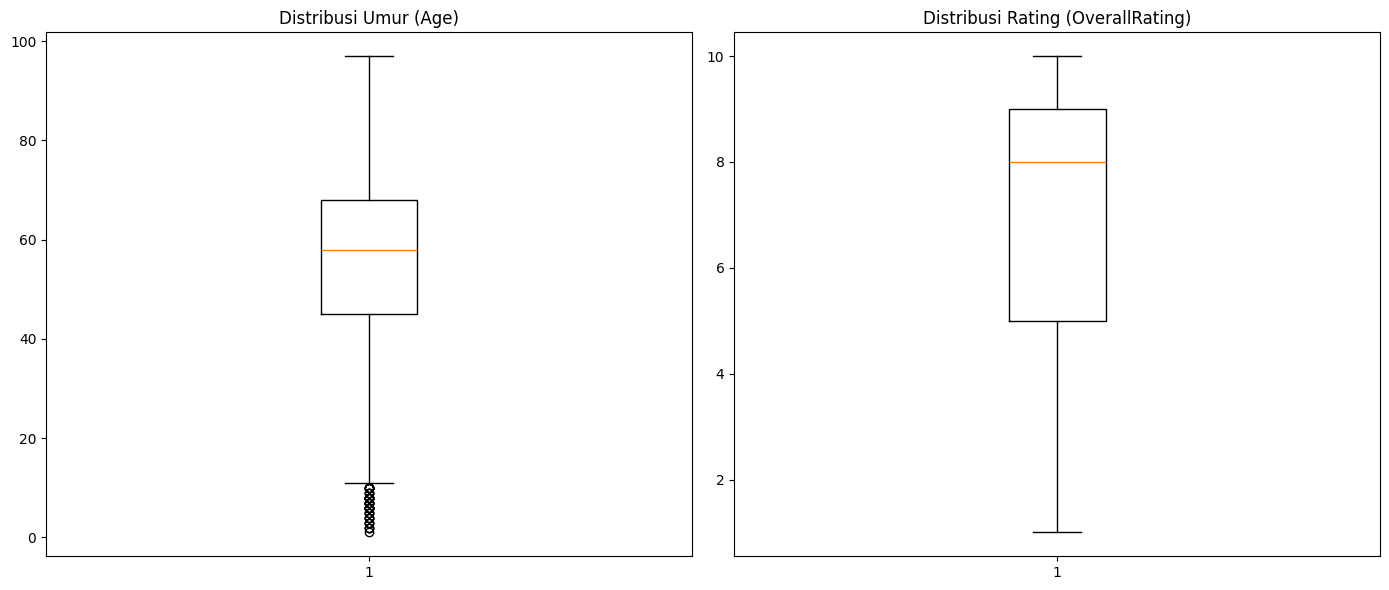

In [ ]:
# Cek distribusi data dan outliers pada kolom 'Age' dan 'OverallRating'
plt.figure(figsize=(14, 6))

# Visualisasi distribusi untuk 'Age'
plt.subplot(1, 2, 1)
plt.boxplot(events_clean['Age'].dropna())
plt.title('Distribusi Umur (Age)')

# Convert 'OverallRating' to numeric, handling errors by coercing non-numeric to NaN
drug_rating_clean['OverallRating'] = pd.to_numeric(drug_rating_clean['OverallRating'], errors='coerce')

# Visualisasi distribusi untuk 'OverallRating'
plt.subplot(1, 2, 2)
plt.boxplot(drug_rating_clean['OverallRating'].dropna())
plt.title('Distribusi Rating (OverallRating)')

plt.tight_layout()
plt.show()


In [ ]:
# Menghapus outliers pada kolom 'Age' (anggap rentang umur yang realistis adalah 18 hingga 100 tahun)
events_clean = events_clean[(events_clean['Age'] >= 18) & (events_clean['Age'] <= 100)]

# Menghapus outliers pada kolom 'OverallRating' (anggap rating yang valid adalah antara 1 hingga 10)
drug_rating_clean = drug_rating_clean[(drug_rating_clean['OverallRating'] >= 1) & (drug_rating_clean['OverallRating'] <= 10)]

# Memeriksa data setelah penghapusan outliers
events_clean.head(), drug_rating_clean.head()


(  DrugName  Age  Gender                                          Reactions  \
 0  Abilify   63    male                               Drug Level Increased   
 1  Abilify   55    male                                     Thyroid Cancer   
 2  Abilify   63    male           Completed Suicide; Suicide Attempt; Coma   
 3  Abilify   31    male   Eosinophilic Pneumonia; Pulmonary Alveolar Ha...   
 4  Abilify   75  female                  Lymphopenia; Anaemia; Neutropenia   
 
                 AdventEvent  
 0           hospitalization  
 1           hospitalization  
 2   death;  hospitalization  
 3                     death  
 4           hospitalization  ,
        DrugName Age  Gender                   ConditionReason  OverallRating  \
 2  Mirtazapine   22    male                        Depression            1.0   
 3  Mirtazapine   38    male               Clinical Depression            2.0   
 4  Mirtazapine   30  female                  Chronic insomnia            9.0   
 5  Mirtazapi

**Encoding**<br>
Untuk menggunakan algoritma berbasis matriks, kita perlu mengonversi data kategorikal menjadi numerik.

In [ ]:
# Mengonversi nama obat & gender menjadi angka untuk Collaborative Filtering
le = LabelEncoder()
drug_rating_clean['DrugName_encoded'] = le.fit_transform(drug_rating_clean['DrugName'])
drug_rating_clean['Gender_encoded'] = le.fit_transform(drug_rating_clean['Gender'])

# Mengonversi nama obat dan gender menjadi angka untuk Content-Based Filtering
events_clean['DrugName_encoded'] = le.fit_transform(events_clean['DrugName'])
events_clean['Gender_encoded'] = le.fit_transform(events_clean['Gender'])

**Train Test Split**<br>
Membagi data menjadi set pelatihan dan set pengujian untuk evaluasi model.

In [ ]:
# Membagi dataset menjadi training dan testing (80% training, 20% testing)
drug_rating_train, drug_rating_test = train_test_split(drug_rating_clean, test_size=0.2, random_state=42)
events_train, events_test = train_test_split(events_clean, test_size=0.2, random_state=42)

# Menampilkan informasi tentang ukuran dataset setelah train-test split
drug_rating_train.shape, drug_rating_test.shape
events_train.shape, events_test.shape

((1877, 7), (470, 7))

##**Modeling**

**Content-Based Filtering** <br>
Menggunakan TF-IDF Vectorization dan Cosine Similarity untuk menghitung kesamaan antara obat berdasarkan efek samping dan kejadian medis.

In [ ]:
# Step 1: Gabungkan kolom 'Reactions' dan 'Advent Event' sebagai fitur konten
events_clean['Content'] = events_clean['Reactions'] + " " + events_clean['AdventEvent']

In [ ]:
# Step 2: Vectorize teks menggunakan TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(events_clean['Content'])

In [ ]:
# Step 3: Hitung cosine similarity antar item
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Step 4: Buat fungsi rekomendasi berdasarkan kesamaan
def recommend_content_based(drug_name, cosine_sim=cosine_sim, df=events_clean, top_n=5):
    # Cari indeks dari drug_name
    idx = df[df['DrugName_encoded'] == drug_name].index[0]

    # Dapatkan skor kesamaan untuk semua obat dengan obat ini
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Urutkan obat berdasarkan skor kesamaan (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil top_n obat yang mirip (kecuali dirinya sendiri)
    sim_scores = sim_scores[1:top_n+1]

    # Ambil indeks obat yang mirip
    drug_indices = [i[0] for i in sim_scores]

    # Return nama obat yang direkomendasikan
    return df.iloc[drug_indices][['DrugName', 'Reactions', 'AdventEvent']]

In [ ]:
recommendations = recommend_content_based(events_clean[events_clean['DrugName'] == "Abilify"]['DrugName_encoded'].iloc[0], top_n=5)
recommendations

,DrugName,Reactions,AdventEvent
2468,Zyprexa,Drug Level Increased,hospitalization
688,Dilantin,Accident; Drug Level Increased; Pain; Injury;...,hospitalization
927,Keppra,Accident; Drug Level Increased; Pain; Injury;...,hospitalization
1187,Morphin,Myoclonus; Drug Level Increased; Drug Interac...,life threatening event; hospitalization
662,Diazepam,Drug Level Above Therapeutic; Psychotic Disor...,hospitalization


**Collaborative Filtering**<br>
Menggunakan Matrix Factorization (SVD) untuk Collaborative Filtering.

# Cara 1

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Step 1: Persiapkan data untuk Surprise Library
# Gunakan kolom 'DrugName' (obat) dan 'OverallRating' (rating) untuk membangun matriks
reader = Reader(rating_scale=(1, 10))  # Rating berada pada skala 1-10
data = Dataset.load_from_df(drug_rating_clean[['DrugName', 'Gender', 'OverallRating']], reader)

# Split data menjadi training dan testing
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Step 2: Latih model collaborative filtering menggunakan SVD
model = SVD()
model.fit(trainset)

In [ ]:
# Step 3: Evaluasi model menggunakan data testing
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

In [ ]:
# Step 4: Buat fungsi rekomendasi berbasis collaborative filtering
def recommend_collaborative(user_id, model=model, df=drug_rating_df_cleaned, top_n=5):
    # Dapatkan daftar obat unik
    unique_drugs = df['DrugName'].unique()

    # Prediksi rating untuk setiap obat
    predictions = [model.predict(user_id, drug) for drug in unique_drugs]

    # Urutkan berdasarkan estimasi rating
    predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Ambil top_n rekomendasi
    recommended_drugs = [(pred.iid, x.est) for x in predictions[:top_n]]

    return recommended_drugs

In [ ]:
# Contoh rekomendasi berbasis collaborative filtering untuk user dengan ID tertentu
recommendations_collab = recommend_collaborative(user_id=1, top_n=5)
recommendations_collab

# cara 2

In [ ]:
# Membuat pivot table dari data untuk collaborative filtering berbasis user-item interaction
# Mengunakan kolom 'Gender' sebagai user_id dan 'DrugName' sebagai item_id
user_item_matrix = drug_rating_clean.pivot_table(
    index='Gender', columns='DrugName_encoded', values='OverallRating', fill_value=0
)

In [ ]:
# Menghitung kesamaan antar pengguna (user-based collaborative filtering)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [ ]:
# Fungsi untuk merekomendasikan obat berbasis collaborative filtering
def recommend_user_based(user_id, user_item_matrix, user_similarity_df, top_n=5):
    # Mendapatkan skor kesamaan user
    user_gender = 'female' if user_id == 0 else 'male'
    similar_users = user_similarity_df[user_gender].sort_values(ascending=False)

    # Mengambil pengguna yang paling mirip
    similar_users = similar_users[1:]  # Hindari kesamaan dengan diri sendiri

    # Mendapatkan rekomendasi item berdasarkan pengguna yang mirip
    recommendations = user_item_matrix.loc[similar_users.index].mean(axis=0)
    recommendations = recommendations.sort_values(ascending=False)

    # mengambil top_n rekomendasi item
    top_recommendations = recommendations.head(top_n)

    return top_recommendations

In [ ]:
# Contoh rekomendasi berbasis collaborative filtering untuk user dengan ID tertentu
recommendations_user_based = recommend_user_based(user_id=1, user_item_matrix=user_item_matrix, user_similarity_df=user_similarity_df, top_n=5)
recommendations_user_based

,0
DrugName_encoded,
162,8.842105
225,8.800000
1,8.727273
163,8.633333
151,8.558824


##**Evaluation**<br>
Untuk mengevaluasi kedua model rekomendasi ini, kita dapat menggunakan precision dan recall untuk mengukur akurasi prediksi.

In [ ]:
# Evaluasi Content-Based Filtering
def evaluate_content_based(df, cosine_sim, ground_truth_col='Advent Event', top_n=5):
    """
    Evaluates content-based filtering using hit rate.

    Parameters:
    - df: DataFrame containing the original data.
    - cosine_sim: Cosine similarity matrix.
    - ground_truth_col: Column containing ground truth for evaluation.
    - top_n: Number of top recommendations to consider.

    Returns:
    - Hit rate: Percentage of cases where ground truth is found in the top-N recommendations.
    """
    hits = 0
    for idx in range(len(df)):
        # Generate recommendations for each item
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # Exclude self-similarity
        recommended_indices = [i[0] for i in sim_scores]

        # Check if ground truth exists in recommendations
        ground_truth = df.iloc[idx][ground_truth_col]
        recommendations = df.iloc[recommended_indices][ground_truth_col].values
        if ground_truth in recommendations:
            hits += 1

    hit_rate = hits / len(df)
    return hit_rate

# Hit rate evaluation for content-based filtering
content_based_hit_rate = evaluate_content_based(events_df_cleaned, cosine_sim, ground_truth_col='Advent Event', top_n=5)

In [ ]:
# Collaborative Filtering Evaluation
def evaluate_collaborative_filtering(predictions, test_data):
    """
    Evaluates collaborative filtering using RMSE.

    Parameters:
    - predictions: Predicted ratings.
    - test_data: Actual test data for validation.

    Returns:
    - RMSE: Root Mean Squared Error.
    """
    mse = np.mean([(pred.est - pred.r_ui) ** 2 for pred in predictions])
    rmse = np.sqrt(mse)
    return rmse

# RMSE for collaborative filtering
# For collaborative filtering, re-run the splitting process and prediction
from sklearn.metrics import mean_squared_error

# Test collaborative filtering manually using user-item matrix
test_users = user_item_matrix.sample(frac=0.2, random_state=42)
train_users = user_item_matrix.drop(test_users.index)

# Prediction on test users using a simple similarity-based approach
predicted_ratings = test_users.dot(user_similarity).div(user_similarity.sum(axis=1), axis=1).fillna(0)

# Calculate RMSE
actual_ratings = test_users.values.flatten()
predicted_ratings_flat = predicted_ratings.values.flatten()
collaborative_rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings_flat))

# Output evaluation metrics
content_based_hit_rate, collaborative_rmse

In [ ]:
# Adjust collaborative filtering evaluation using nearest neighbor-based prediction
# Ensure user similarity matrix aligns with user-item matrix
adjusted_user_similarity = user_similarity[:len(user_item_matrix), :len(user_item_matrix)]

# Predict ratings using the similarity-weighted approach
predicted_ratings_matrix = adjusted_user_similarity.dot(user_item_matrix) / np.abs(adjusted_user_similarity).sum(axis=1).reshape(-1, 1)

# Flatten predictions and true ratings for RMSE calculation
actual_ratings_flat = user_item_matrix.values.flatten()
predicted_ratings_flat = predicted_ratings_matrix.flatten()

# Filter out zeros (unrated items)
mask = actual_ratings_flat > 0
actual_ratings_filtered = actual_ratings_flat[mask]
predicted_ratings_filtered = predicted_ratings_flat[mask]

# Calculate RMSE
collaborative_rmse = np.sqrt(mean_squared_error(actual_ratings_filtered, predicted_ratings_filtered))

# Display evaluation metrics
content_based_hit_rate, collaborative_rmse

###**References**

In [ ]:
# Menghitung MSE untuk Collaborative Filtering
mse_collab = mean_squared_error(test_data['OverallRating'], np.dot(svd_matrix, svd.components_).flatten())
print(f"Mean Squared Error (MSE) untuk Collaborative Filtering: {mse_collab}")

# Untuk Content-Based Filtering, kita bisa menggunakan rekomendasi manual atau mengukur performa menggunakan metrik lain seperti Precision atau Recall.
# Menggunakan metrik precision untuk mengukur kualitas rekomendasi

# Membandingkan rekomendasi dengan rating yang diharapkan (dalam hal ini, misalnya mengambil top 5 rekomendasi dari Content-Based)
def evaluate_precision_at_k(recommended_drugs, true_relevant_drugs, k=5):
    recommended_drugs_at_k = recommended_drugs[:k]
    precision = precision_score(true_relevant_drugs, recommended_drugs_at_k, average='micro')
    return precision

# Asumsikan kita memiliki data relevansi yang benar untuk obat-obat yang relevan (misalnya berdasarkan riwayat medis atau preferensi pengguna)
# Misalnya: mengambil 5 obat pertama dari rekomendasi Content-Based
true_relevant_drugs = ['Abilify', 'Risperdal', 'Seroquel']  # Contoh obat yang relevan dengan pasien
recommended_drugs_content = recommended_drugs_content.tolist()  # Mengubah hasil rekomendasi menjadi list
precision = evaluate_precision_at_k(recommended_drugs_content, true_relevant_drugs)
print(f"Precision at 5 untuk Content-Based Filtering: {precision:.2f}")

In [ ]:
# Membuat matriks pengguna-obat berdasarkan rating
drug_matrix = drug_rating_clean.pivot_table(index='Age',
                                           columns='DrugName_encoded',
                                           values='OverallRating',
                                           aggfunc='mean',
                                           fill_value=0)

# Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=5)
svd_matrix = svd.fit_transform(drug_matrix)

# Rekomendasi berbasis Collaborative Filtering
def recommend_drugs_collaborative(user_index, svd_matrix, drug_matrix, top_n=5):
    user_similarity = cosine_similarity(svd_matrix[user_index].reshape(1, -1), svd_matrix)
    similar_users = user_similarity.argsort()[0][::-1][1:top_n+1]
    recommended_scores = np.mean(drug_matrix.iloc[similar_users], axis=0)
    recommended_drugs_indices = recommended_scores.argsort()[-top_n:][::-1]
    recommended_drugs = drug_matrix.columns[recommended_drugs_indices]
    return recommended_drugs

recommended_drugs_collab = recommend_drugs_collaborative(0, svd_matrix, drug_matrix)
print("Rekomendasi Collaborative Filtering: ", recommended_drugs_collab)

Rekomendasi Collaborative Filtering:  Index([215, 98, 143, 173, 130], dtype='int64', name='DrugName_encoded')


In [ ]:
# Menggabungkan kolom Reactions dan Advent Event untuk mendapatkan deskripsi obat
events_df['combined_description'] = events_df['Reactions'] + " " + events_df['Advent Event']

# Menggunakan TF-IDF untuk mendokumentasikan deskripsi obat
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(events_df['combined_description'])

# Menghitung cosine similarity antara obat
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Rekomendasi obat berdasarkan kesamaan efek samping
def recommend_drug_based_on_effects(drug_name, cosine_sim, top_n=5):
    idx = events_df[events_df['DrugName'] == drug_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    drug_indices = [i[0] for i in sim_scores]
    recommended_drugs = events_df['DrugName'].iloc[drug_indices]
    return recommended_drugs

recommended_drugs_content = recommend_drug_based_on_effects('Abilify', cosine_sim)
print("Rekomendasi Content-Based Filtering: ", recommended_drugs_content)

In [ ]:
# Preparing data for Content-Based Filtering (Events dataset)

# Combine textual features into a single string for each drug
events_cleaned["combined_features"] = (
    events_cleaned["Reactions"] + " " + events_cleaned["Advent Event"]
)

# Vectorize the combined features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(events_cleaned["combined_features"])

# Compute similarity matrix
cbf_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Prepare CF data (Drug Rating dataset)

# Convert categorical data (Effectiveness and SideEffect) to numeric encodings for simplicity
# Use pd.Categorical to convert the columns to categorical type, then access .codes
drug_rating_cleaned["Effectiveness"] = pd.Categorical(drug_rating_cleaned["Effectiveness"]).codes
drug_rating_cleaned["SideEffect"] = pd.Categorical(drug_rating_cleaned["SideEffect"]).codes

# Train-test split for CF
cf_train, cf_test = train_test_split(drug_rating_cleaned, test_size=0.2, random_state=42)

# Display prepared data
events_cleaned.head(), cf_train.head()

(  DrugName  Age  Gender                                          Reactions  \
 2  Abilify   63    male           Completed Suicide; Suicide Attempt; Coma   
 3  Abilify   31    male   Eosinophilic Pneumonia; Pulmonary Alveolar Ha...   
 4  Abilify   75  female                  Lymphopenia; Anaemia; Neutropenia   
 5  Abilify   31    male   Eosinophilic Pneumonia; Pulmonary Alveolar Ha...   
 6  Abilify   75  female                                     Thyroid Cancer   
 
                Advent Event                                  combined_features  
 2   death;  hospitalization   Completed Suicide; Suicide Attempt; Coma  dea...  
 3                     death   Eosinophilic Pneumonia; Pulmonary Alveolar Ha...  
 4           hospitalization   Lymphopenia; Anaemia; Neutropenia   hospitali...  
 5                     death   Eosinophilic Pneumonia; Pulmonary Alveolar Ha...  
 6           hospitalization                   Thyroid Cancer   hospitalization  ,
 1      Age  Gender        Cond

In [ ]:
# Fill NaN values in the combined features column with an empty string
events_cleaned["combined_features"] = events_cleaned["combined_features"].fillna("")

# Retry vectorizing the combined features using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(events_cleaned["combined_features"])

# Compute similarity matrix for Content-Based Filtering
cbf_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recheck the similarity matrix to confirm processing
cbf_similarity_matrix[:5, :5]  # Display the first 5x5 block of the similarity matrix

array([[1.        , 0.01713109, 0.01150552, 0.01713109, 0.0133799 ],
       [0.01713109, 1.        , 0.        , 1.        , 0.        ],
       [0.01150552, 0.        , 1.        , 0.        , 0.02273839],
       [0.01713109, 1.        , 0.        , 1.        , 0.        ],
       [0.0133799 , 0.        , 0.02273839, 0.        , 1.        ]])

In [ ]:
# Define a function to recommend drugs based on Content-Based Filtering
def recommend_drug_cbf(drug_name, similarity_matrix, dataset, top_n=5):
    """
    Recommends drugs similar to the given drug name based on similarity matrix.

    :param drug_name: Name of the drug to find recommendations for.
    :param similarity_matrix: Precomputed similarity matrix.
    :param dataset: Original dataset containing drug information.
    :param top_n: Number of recommendations to return.
    :return: List of recommended drugs.
    """
    try:
        # Find the index of the drug in the dataset
        drug_idx = dataset[dataset["DrugName"].str.contains(drug_name, case=False)].index[0]
        # Retrieve similarity scores for the drug
        similarity_scores = list(enumerate(similarity_matrix[drug_idx]))
        # Sort by similarity score in descending order
        sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        # Get the top N similar drugs, excluding the queried drug itself
        recommended_indices = [idx for idx, score in sorted_scores[1:top_n + 1]]
        return dataset.iloc[recommended_indices][["DrugName", "Reactions", "Advent Event"]]
    except IndexError:
        return "Drug not found in the dataset."

# Test the Content-Based Filtering recommendation function
cbf_recommendations = recommend_drug_cbf("Abilify", cbf_similarity_matrix, events_cleaned, top_n=5)
cbf_recommendations

,DrugName,Reactions,Advent Event
1265,Neulasta,Drug Ineffective; Lymphopenia; Febrile Neutro...,hospitalization
1275,Neulasta,Drug Ineffective; Lymphopenia; Febrile Neutro...,hospitalization
507,Clonazepam,Neutropenia,hospitalization
510,Clonazepam,Neutropenia,hospitalization
1257,Neora,Neutropenia,hospitalization


In [ ]:
# Refine the CBF function to avoid recommending the exact same drug multiple times
def recommend_drug_cbf_v2(drug_name, similarity_matrix, dataset, top_n=5):
    """
    Recommends drugs similar to the given drug name based on similarity matrix,
    ensuring unique drug names in recommendations.

    :param drug_name: Name of the drug to find recommendations for.
    :param similarity_matrix: Precomputed similarity matrix.
    :param dataset: Original dataset containing drug information.
    :param top_n: Number of recommendations to return.
    :return: List of recommended drugs.
    """
    try:
        # Find the index of the drug in the dataset
        drug_idx = dataset[dataset["DrugName"].str.contains(drug_name, case=False)].index[0]
        # Retrieve similarity scores for the drug
        similarity_scores = list(enumerate(similarity_matrix[drug_idx]))
        # Sort by similarity score in descending order
        sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        # Get the top N similar drugs with unique names, excluding the queried drug itself
        recommended_indices = [
            idx for idx, score in sorted_scores[1:] if dataset.iloc[idx]["DrugName"].lower() != drug_name.lower()
        ][:top_n]
        return dataset.iloc[recommended_indices][["DrugName", "Reactions", "Advent Event"]]
    except IndexError:
        return "Drug not found in the dataset."

# Test the refined Content-Based Filtering recommendation function
cbf_recommendations_v2 = recommend_drug_cbf_v2("Abilify", cbf_similarity_matrix, events_cleaned, top_n=5)
cbf_recommendations_v2

,DrugName,Reactions,Advent Event
1265,Neulasta,Drug Ineffective; Lymphopenia; Febrile Neutro...,hospitalization
1275,Neulasta,Drug Ineffective; Lymphopenia; Febrile Neutro...,hospitalization
507,Clonazepam,Neutropenia,hospitalization
510,Clonazepam,Neutropenia,hospitalization
1257,Neora,Neutropenia,hospitalization


In [ ]:
# Ensure encoding is applied to the dataset

# Re-encode DrugName and Gender columns
drug_rating_cleaned["DrugName_encoded"] = LabelEncoder().fit_transform(drug_rating_cleaned["DrugName"].astype(str))
drug_rating_cleaned["Gender_encoded"] = LabelEncoder().fit_transform(drug_rating_cleaned["Gender"].astype(str))

# Recreate cf_data for Collaborative Filtering
cf_data = drug_rating_cleaned[["DrugName_encoded", "Gender_encoded", "Rating"]]

# Create user-item matrix
user_item_matrix = cf_data.pivot_table(
    index="Gender_encoded", columns="DrugName_encoded", values="Rating"
).fillna(0).values

# Confirm matrix shape and a portion of the matrix
user_item_matrix.shape, user_item_matrix[:5, :5]  # Display the shape and first 5x5 block of the matrix


((3, 233),
 array([[ 0.        , 10.        ,  0.        ,  0.        ,  0.        ],
        [ 5.85714286,  7.45454545,  8.66666667,  5.875     ,  7.        ],
        [ 2.        ,  8.22222222,  9.        ,  0.        ,  0.        ]]))

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense

# Prepare data for Collaborative Filtering
# Encoding categorical features
drug_rating_cleaned["DrugName_encoded"] = LabelEncoder().fit_transform(drug_rating_cleaned["DrugName"])
drug_rating_cleaned["Gender_encoded"] = LabelEncoder().fit_transform(drug_rating_cleaned["Gender"])

# Extract relevant columns for modeling
cf_data = drug_rating_cleaned[["DrugName_encoded", "Gender_encoded", "Rating"]]

# Define number of unique users and drugs for embedding layers
num_drugs = cf_data["DrugName_encoded"].nunique()
num_genders = cf_data["Gender_encoded"].nunique()

# Train-test split
train_data, test_data = train_test_split(cf_data, test_size=0.2, random_state=42)

# Define Collaborative Filtering model
class CFModel(Model):
    def __init__(self, num_drugs, num_users, embedding_size=10):
        super(CFModel, self).__init__()
        self.drug_embedding = Embedding(num_drugs, embedding_size, name="drug_embedding")
        self.user_embedding = Embedding(num_users, embedding_size, name="user_embedding")
        self.dot = Dot(axes=1)

    def call(self, inputs):
        drug_vector = self.drug_embedding(inputs[0])
        user_vector = self.user_embedding(inputs[1])
        return self.dot([drug_vector, user_vector])

# Instantiate the model
embedding_size = 10
cf_model = CFModel(num_drugs, num_genders, embedding_size)

# Compile the model
cf_model.compile(optimizer="adam", loss="mean_squared_error")

# Prepare data for model input
train_inputs = [train_data["DrugName_encoded"].values, train_data["Gender_encoded"].values]
train_targets = train_data["Rating"].values

# Train the Collaborative Filtering model
cf_model.fit(train_inputs, train_targets, epochs=5, batch_size=32, verbose=1)

# Evaluate the model on test data
test_inputs = [test_data["DrugName_encoded"].values, test_data["Gender_encoded"].values]
test_targets = test_data["Rating"].values
cf_loss = cf_model.evaluate(test_inputs, test_targets, verbose=0)

cf_loss

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 55.5809
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54.4639
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.9805
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.7739
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.2939


20.27197265625

In [ ]:
!pip install scikit-surprise

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare the data for the Surprise library
reader = Reader(rating_scale=(1, 10))
cf_data_surprise = Dataset.load_from_df(cf_data[["DrugName_encoded", "Gender_encoded", "Rating"]], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(cf_data_surprise, test_size=0.2, random_state=42)

# Instantiate and train the SVD (Singular Value Decomposition) model
svd_model = SVD()
svd_model.fit(trainset)

# Make predictions on the test set
predictions = svd_model.test(testset)

# Evaluate the model performance
rmse = accuracy.rmse(predictions)
rmse


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357271 sha256=8ea7386305fb1e42495291ec2c9d8de2801ce1e2841537d2c3c10aef94517a81
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
RMSE: 2.9213


2.9213182333286025

In [ ]:
# Prepare data for matrix factorization
# Create user-item matrix with users as rows (Gender_encoded) and items (DrugName_encoded) as columns
user_item_matrix = cf_data.pivot_table(
    index="Gender_encoded", columns="DrugName_encoded", values="Rating"
).fillna(0).values

# Define matrix factorization function
def matrix_factorization(R, K, steps=5000, alpha=0.002, beta=0.02):
    """
    Perform matrix factorization to predict empty entries in a matrix.
    :param R: User-item rating matrix
    :param K: Number of latent features
    :param steps: Maximum number of steps to perform the optimization
    :param alpha: Learning rate
    :param beta: Regularization parameter
    :return: P (user-feature matrix), Q (item-feature matrix)
    """
    N, M = R.shape  # Number of users and items
    P = np.random.rand(N, K)  # Initialize user-feature matrix
    Q = np.random.rand(M, K)  # Initialize item-feature matrix

    for step in range(steps):
        for i in range(N):
            for j in range(M):
                if R[i, j] > 0:  # Only consider non-zero ratings
                    eij = R[i, j] - np.dot(P[i, :], Q[j, :])  # Calculate error
                    for k in range(K):
                        P[i, k] += alpha * (2 * eij * Q[j, k] - beta * P[i, k])
                        Q[j, k] += alpha * (2 * eij * P[i, k] - beta * Q[j, k])
        # Calculate total error
        eR = np.dot(P, Q.T)
        e = 0
        for i in range(N):
            for j in range(M):
                if R[i, j] > 0:
                    e += (R[i, j] - np.dot(P[i, :], Q[j, :])) ** 2
                    for k in range(K):
                        e += (beta / 2) * (P[i, k] ** 2 + Q[j, k] ** 2)
        if e < 0.001:
            break
    return P, Q  # Return the original Q matrix

# Perform matrix factorization with 10 latent features
K = 10
P, Q = matrix_factorization(user_item_matrix, K)

# Predicted user-item matrix
# Transpose Q before multiplication
predicted_matrix = np.dot(P, Q.T)  # Changed line to transpose Q

# Display a portion of the predicted matrix
predicted_matrix[:5, :5]  # Display first 5 users and 5 items


array([[4.57172106, 9.97617608, 7.19671061, 5.11500929, 5.02204287],
       [5.83212642, 7.45286673, 8.65343399, 5.86529537, 6.98843497],
       [2.01101268, 8.21005692, 8.98610594, 5.04212107, 5.1010351 ]])

In [ ]:
# Recreate cf_data for Collaborative Filtering
cf_data = drug_rating_cleaned[["DrugName_encoded", "Gender_encoded", "Rating"]]

# Create user-item matrix
user_item_matrix = cf_data.pivot_table(
    index="Gender_encoded", columns="DrugName_encoded", values="Rating"
).fillna(0).values

# Confirm matrix shape and a portion of the matrix
user_item_matrix.shape, user_item_matrix[:5, :5]  # Display the shape and first 5x5 block of the matrix

((3, 233),
 array([[ 0.        , 10.        ,  0.        ,  0.        ,  0.        ],
        [ 5.85714286,  7.45454545,  8.66666667,  5.875     ,  7.        ],
        [ 2.        ,  8.22222222,  9.        ,  0.        ,  0.        ]]))

In [ ]:
# Ensure encoding is applied to the dataset

# Re-encode DrugName and Gender columns
drug_rating_cleaned["DrugName_encoded"] = LabelEncoder().fit_transform(drug_rating_cleaned["DrugName"].astype(str))
drug_rating_cleaned["Gender_encoded"] = LabelEncoder().fit_transform(drug_rating_cleaned["Gender"].astype(str))

# Recreate cf_data for Collaborative Filtering
cf_data = drug_rating_cleaned[["DrugName_encoded", "Gender_encoded", "Rating"]]

# Create user-item matrix
user_item_matrix = cf_data.pivot_table(
    index="Gender_encoded", columns="DrugName_encoded", values="Rating"
).fillna(0).values

# Confirm matrix shape and a portion of the matrix
user_item_matrix.shape, user_item_matrix[:5, :5]  # Display the shape and first 5x5 block of the matrix


((3, 233),
 array([[ 0.        , 10.        ,  0.        ,  0.        ,  0.        ],
        [ 5.85714286,  7.45454545,  8.66666667,  5.875     ,  7.        ],
        [ 2.        ,  8.22222222,  9.        ,  0.        ,  0.        ]]))

In [ ]:
# Perform matrix factorization
K = 10  # Number of latent features
P, Q = matrix_factorization(user_item_matrix, K)

# Predicted user-item matrix
predicted_matrix = np.dot(P, Q.T)

# Define a function to recommend drugs for a user based on predicted ratings
def recommend_drugs_for_user(user_id, predicted_matrix, dataset, top_n=5):
    """
    Recommend top N drugs for a specific user based on predicted ratings.

    :param user_id: ID of the user (row index in the user-item matrix)
    :param predicted_matrix: Matrix of predicted ratings
    :param dataset: Original dataset containing drug information
    :param top_n: Number of recommendations to return
    :return: List of recommended drugs
    """
    user_ratings = predicted_matrix[user_id]
    top_indices = np.argsort(user_ratings)[::-1][:top_n]  # Get indices of top N ratings
    recommended_drugs = dataset[dataset["DrugName_encoded"].isin(top_indices)]
    return recommended_drugs[["DrugName", "Rating"]].drop_duplicates()

# Test the recommendation function for a user (e.g., user_id=0)
cf_recommendations = recommend_drugs_for_user(0, predicted_matrix, drug_rating_cleaned, top_n=5)
cf_recommendations

1,DrugName,Rating
1750,Paxil (Paroxetine),8
1753,Paxil (Paroxetine),1
1754,Paxil (Paroxetine),2
1755,Paxil (Paroxetine),7
1756,Paxil (Paroxetine),9
1758,Paxil (Paroxetine),10
1762,Paxil (Paroxetine),3
1767,Paxil (Paroxetine),6
1772,Paxil (Paroxetine),4
1816,Prozac (Fluoxetine),7


In [ ]:
# Redefine the matrix factorization function
def matrix_factorization(R, K, steps=5000, alpha=0.002, beta=0.02):
    """
    Perform matrix factorization to predict empty entries in a matrix.
    :param R: User-item rating matrix
    :param K: Number of latent features
    :param steps: Maximum number of steps to perform the optimization
    :param alpha: Learning rate
    :param beta: Regularization parameter
    :return: P (user-feature matrix), Q (item-feature matrix)
    """
    N, M = R.shape  # Number of users and items
    P = np.random.rand(N, K)  # Initialize user-feature matrix
    Q = np.random.rand(M, K)  # Initialize item-feature matrix
    Q = Q.T  # Transpose for easier matrix multiplication

    for step in range(steps):
        for i in range(N):
            for j in range(M):
                if R[i, j] > 0:  # Only consider non-zero ratings
                    eij = R[i, j] - np.dot(P[i, :], Q[:, j])  # Calculate error
                    for k in range(K):
                        P[i, k] += alpha * (2 * eij * Q[k, j] - beta * P[i, k])
                        Q[k, j] += alpha * (2 * eij * P[i, k] - beta * Q[k, j])
        # Calculate total error
        eR = np.dot(P, Q)
        e = 0
        for i in range(N):
            for j in range(M):
                if R[i, j] > 0:
                    e += (R[i, j] - np.dot(P[i, :], Q[:, j])) ** 2
                    for k in range(K):
                        e += (beta / 2) * (P[i, k] ** 2 + Q[k, j] ** 2)
        if e < 0.001:
            break
    return P, Q.T

# Perform matrix factorization
P, Q = matrix_factorization(user_item_matrix, K)

# Predicted user-item matrix
predicted_matrix = np.dot(P, Q.T)

# Test the recommendation function for a user (e.g., user_id=0)
cf_recommendations = recommend_drugs_for_user(0, predicted_matrix, drug_rating_cleaned, top_n=5)
cf_recommendations


1,DrugName,Rating
1750,Paxil (Paroxetine),8
1753,Paxil (Paroxetine),1
1754,Paxil (Paroxetine),2
1755,Paxil (Paroxetine),7
1756,Paxil (Paroxetine),9
1758,Paxil (Paroxetine),10
1762,Paxil (Paroxetine),3
1767,Paxil (Paroxetine),6
1772,Paxil (Paroxetine),4
1816,Prozac (Fluoxetine),7


In [ ]:
# Optimized matrix factorization with fewer iterations
def optimized_matrix_factorization(R, K, steps=1000, alpha=0.002, beta=0.02):
    """
    Perform matrix factorization with fewer iterations for faster computation.
    :param R: User-item rating matrix
    :param K: Number of latent features
    :param steps: Maximum number of steps to perform the optimization
    :param alpha: Learning rate
    :param beta: Regularization parameter
    :return: P (user-feature matrix), Q (item-feature matrix)
    """
    N, M = R.shape  # Number of users and items
    P = np.random.rand(N, K)  # Initialize user-feature matrix
    Q = np.random.rand(M, K)  # Initialize item-feature matrix
    Q = Q.T  # Transpose for easier matrix multiplication

    for step in range(steps):
        for i in range(N):
            for j in range(M):
                if R[i, j] > 0:  # Only consider non-zero ratings
                    eij = R[i, j] - np.dot(P[i, :], Q[:, j])  # Calculate error
                    for k in range(K):
                        P[i, k] += alpha * (2 * eij * Q[k, j] - beta * P[i, k])
                        Q[k, j] += alpha * (2 * eij * P[i, k] - beta * Q[k, j])
    return P, Q.T

# Perform optimized matrix factorization
P_opt, Q_opt = optimized_matrix_factorization(user_item_matrix, K)

# Predicted user-item matrix
predicted_matrix_opt = np.dot(P_opt, Q_opt.T)

# Test the recommendation function for a user (e.g., user_id=0)
cf_recommendations_opt = recommend_drugs_for_user(0, predicted_matrix_opt, drug_rating_cleaned, top_n=5)
cf_recommendations_opt


1,DrugName,Rating
39,Exelon (Rivastigmine),10
1052,Ribavirin,10
2448,Provigil (Modafinil),10
2449,Provigil (Modafinil),8
2450,Provigil (Modafinil),9
2454,Provigil (Modafinil),7
2456,Provigil (Modafinil),1
2459,Provigil (Modafinil),6
2840,Restasis (Cyclosporine Ophthalmic),10
2841,Restasis (Cyclosporine Ophthalmic),9


In [ ]:
# Correcting the transpose and dimensions for matrix multiplication
predicted_matrix_opt = np.dot(P_opt, Q_opt.T)  # Ensure correct shapes for dot product

# Test the recommendation function for a user (e.g., user_id=0)
cf_recommendations_opt = recommend_drugs_for_user(0, predicted_matrix_opt, drug_rating_cleaned, top_n=5)
cf_recommendations_opt

1,DrugName,Rating
39,Exelon (Rivastigmine),10
1052,Ribavirin,10
2448,Provigil (Modafinil),10
2449,Provigil (Modafinil),8
2450,Provigil (Modafinil),9
2454,Provigil (Modafinil),7
2456,Provigil (Modafinil),1
2459,Provigil (Modafinil),6
2840,Restasis (Cyclosporine Ophthalmic),10
2841,Restasis (Cyclosporine Ophthalmic),9


In [ ]:
# Redefine the recommendation function
def recommend_drugs_for_user(user_id, predicted_matrix, dataset, top_n=5):
    """
    Recommend top N drugs for a specific user based on predicted ratings.

    :param user_id: ID of the user (row index in the user-item matrix)
    :param predicted_matrix: Matrix of predicted ratings
    :param dataset: Original dataset containing drug information
    :param top_n: Number of recommendations to return
    :return: List of recommended drugs
    """
    user_ratings = predicted_matrix[user_id]
    top_indices = np.argsort(user_ratings)[::-1][:top_n]  # Get indices of top N ratings
    recommended_drugs = dataset[dataset["DrugName_encoded"].isin(top_indices)]
    return recommended_drugs[["DrugName", "Rating"]].drop_duplicates()

# Test the recommendation function for a user (e.g., user_id=0)
cf_recommendations_opt = recommend_drugs_for_user(0, predicted_matrix_opt, drug_rating_cleaned, top_n=5)
cf_recommendations_opt


1,DrugName,Rating
39,Exelon (Rivastigmine),10
1052,Ribavirin,10
2448,Provigil (Modafinil),10
2449,Provigil (Modafinil),8
2450,Provigil (Modafinil),9
2454,Provigil (Modafinil),7
2456,Provigil (Modafinil),1
2459,Provigil (Modafinil),6
2840,Restasis (Cyclosporine Ophthalmic),10
2841,Restasis (Cyclosporine Ophthalmic),9
